In [1]:
import os
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from IPython import display

Using TensorFlow backend.


In [2]:
def set_vram_growth():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config = config)
    K.set_session(sess)

In [3]:
set_vram_growth()

In [4]:
import struct
def load_training_set():
    train_x_input = 'train-images.idx3-ubyte'
    train_y_input = 'train-labels.idx1-ubyte'
    file_x = open(train_x_input, 'rb')
    file_y = open(train_y_input, 'rb')
    train_x_origin = file_x.read()
    train_y_origin = file_y.read()
    file_x.close()
    file_y.close()
    
    #mnist training set label format
    magic_number = struct.unpack('>i', train_y_origin[0:4])[0]
    item_count = struct.unpack('>i', train_y_origin[4:8])[0]
    train_y = np.ones((item_count, 1), dtype = 'float32') #just proving it is a REAL image, not a fake image
    
    #mnist training set image format
    magic_number = struct.unpack('>i', train_x_origin[0:4])[0]
    item_count = struct.unpack('>i', train_x_origin[4:8])[0]
    rows = struct.unpack('>i', train_x_origin[8:12])[0]
    cols = struct.unpack('>i', train_x_origin[12:16])[0]
    
    train_x = np.fromstring(train_x_origin[16:], dtype = 'uint8')
    train_x = train_x.astype('float32')
    train_x = train_x.reshape(item_count, rows, cols, 1)
    #train_x = train_x / 255
    train_x = (train_x - 127.5) / 127.5 #rescaled to -1 ~ 1
    return train_x, train_y

In [5]:
train_x, train_y = load_training_set()
print(train_x.dtype, train_x.shape)
print(train_y.dtype, train_y.shape)

float32 (60000, 28, 28, 1)
float32 (60000, 1)


In [6]:
def single_channel_to_rgb(gray):
    ret = np.zeros((gray.shape[0], gray.shape[1], 3))
    for i in range(3):
        #ret[:,:,i] = gray[:,:]
        ret[:,:,i] = (gray[:,:] + 1) / 2
    return ret

index:  5876


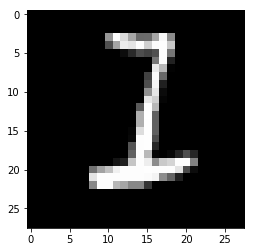

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

test_img_index = random.randint(0, train_x.shape[0] - 1)

print('index: ', test_img_index)
plt.imshow(single_channel_to_rgb(train_x[test_img_index,:,:,0]))

In [8]:
from keras.optimizers import *
opt_discriminator = Adam(0.0002, 0.5) #SGD(lr = 0.0005, momentum = 0.9, nesterov = True)#RMSprop(lr = 0.0008, clipvalue = 1.0, decay = 6e-8)
opt_generator = Adam(0.0002, 0.5) #SGD(lr = 0.0005, momentum = 0.9, nesterov = True) #RMSprop(lr = 0.0004, clipvalue = 1.0, decay = 3e-8)

In [9]:
from keras.models import *
from keras.layers import *
from keras.regularizers import *
def discriminator_model():
    input_shape = (28, 28, 1)
    model_input = Input(shape = input_shape)
    model = Conv2D(32, (3, 3), strides = (2, 2), padding = 'same')(model_input)
    model = LeakyReLU(alpha = 0.2)(model)
    model = Dropout(0.25)(model)
    model = Conv2D(64, (3, 3), strides = (2, 2), padding = 'same')(model)
    model = ZeroPadding2D(padding = ((0,1),(0,1)))(model)
    model = LeakyReLU(alpha = 0.2)(model)
    model = Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Conv2D(128, (3, 3), strides = (2, 2), padding = 'same')(model)
    model = LeakyReLU(alpha = 0.2)(model)
    model = Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Conv2D(256, (3, 3), strides = (1, 1), padding = 'same')(model)
    model = LeakyReLU(alpha = 0.2)(model)
    model = Dropout(0.25)(model)
    
    model = Flatten()(model)
    model = Dense(1)(model)
    
    model = Activation('sigmoid')(model)
    
    
    model = Model(model_input, model)
    model.compile(loss = 'binary_crossentropy', optimizer = opt_discriminator, metrics = ['accuracy'])
    return model

In [10]:
D = discriminator_model()
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

In [11]:
def generator_model():
    input_shape = (100,)
    model_input = Input(shape = input_shape)
    model = Dense(7 * 7 * 128)(model_input)
    model = Activation('relu')(model)
    model = Reshape((7, 7, 128))(model)
    model = BatchNormalization()(model)
    
    model = UpSampling2D()(model)
    model = Conv2D(128, (3, 3), padding = 'same')(model)
    model = Activation('relu')(model)
    model = BatchNormalization()(model)
    model = UpSampling2D()(model)
    model = Conv2D(64, (3, 3), padding = 'same')(model)
    model = Activation('relu')(model)
    model = BatchNormalization()(model)
    #model = Conv2D(32, (3, 3), padding = 'same')(model)
    #model = BatchNormalization()(model)
    #model = Activation('relu')(model)
    model = Conv2D(1, (3, 3), padding = 'same')(model)
    model = Activation('tanh')(model)
    
    
    model = Model(model_input, model)
    model.compile(loss = 'binary_crossentropy', optimizer = opt_generator, metrics = ['accuracy'])
    return model

In [12]:
G = generator_model()
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
activation_2 (Activation)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       147584    
__________

In [13]:
def gan_model(discriminator, generator):
    input_shape = (100,)
    model_input = Input(shape = input_shape)
    model = generator(model_input)
    model = discriminator(model)
    model = Model(model_input, model)
    
    discriminator.trainable = False
    for l in discriminator.layers:
        l.trainable = False
        
    model.compile(loss = 'binary_crossentropy', optimizer = opt_generator, metrics = ['accuracy'])
    
    return model

In [14]:
GAN = gan_model(D, G)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         856705    
_________________________________________________________________
model_1 (Model)              (None, 1)                 392705    
Total params: 1,249,410
Trainable params: 856,065
Non-trainable params: 393,345
_________________________________________________________________


In [15]:
def set_net_trainable(net, trainable):
    net.trainable = trainable
    for l in net.layers:
        l.trainable = trainable

In [16]:
def pretrain_discriminator(discriminator, generator, train_x_real, batch_size = 32, epoches = 3):
    set_net_trainable(discriminator, True)
    for i in range(epoches):
        images_real = train_x_real[np.random.randint(0, train_x_real.shape[0] - 1, size = batch_size),:,:,:]
        noise = np.random.normal(0.0, 1.0, size = [batch_size, 100])
        images_fake = generator.predict(noise)

        batch_train_x = np.concatenate((images_real, images_fake))
        batch_train_y = np.ones([2 * batch_size, 1])
        batch_train_y[batch_size:, :] = 0
        
        discriminator_loss = discriminator.train_on_batch(batch_train_x, batch_train_y)
        if ((i % 10) == 9):
            print('Step ' + str(i + 1) + ' :  Discriminator Loss: ' + str(discriminator_loss))

In [17]:
def test_generator(generator, discriminator):
    noise = np.random.normal(0.0, 1.0, size = [1, 100])
    y_pred = generator.predict(noise)
    plt.figure()
    plt.imshow(single_channel_to_rgb(y_pred[0,:,:,0]))
    plt.show()
    y_true = discriminator.predict(y_pred)
    print('Is True? = ', y_true[0, 0])

In [18]:
def plot_loss(loss):
    display.clear_output(wait = True)
    
    d = loss['d']
    g = loss['g']
    print('Overall training steps: ')
    plt.figure()
    plt.plot(d, label = 'discriminator loss')
    plt.plot(g, label = 'generator loss')
    plt.legend()
    plt.show()
    
    print('Recent 100 training steps:')
    if (len(d) > 100):
        d = d[-100:]
    if (len(g) > 100):
        g = g[-100:]
    plt.figure()
    plt.plot(d, label = 'discriminator loss')
    plt.plot(g, label = 'generator loss')
    plt.legend()
    plt.show()
    
    

In [19]:
def train_model(D, G, GAN, train_x_real, batch_size = 32, epoches = 1000):
    losses = {'d': [], 'g': []}
    half = int(batch_size / 2)
    for i in range(epoches):
        images_real = train_x_real[np.random.randint(0, train_x_real.shape[0] - 1, size = half),:,:,:]
        noise = np.random.normal(0.0, 1.0, size = [half, 100])
        images_fake = G.predict(noise)

        set_net_trainable(D, True)
        discriminator_loss_true = D.train_on_batch(images_real, np.ones([half, 1]))
        discriminator_loss_fake = D.train_on_batch(images_fake, np.zeros([half, 1]))
        discriminator_loss = np.add(discriminator_loss_true, discriminator_loss_fake) / 2
        
        batch_train_y = np.ones([batch_size, 1])
        noise = np.random.normal(0.0, 1.0, size = [batch_size, 100])

        set_net_trainable(D, False)
        generator_loss = GAN.train_on_batch(noise, batch_train_y)
        
        losses['d'].append(discriminator_loss[0])
        losses['g'].append(generator_loss[0])
        
        if ((i % 10) == 9):
            plot_loss(losses)
            print('Step ' + str(i + 1) + ' : Generator Loss: ' + str(generator_loss) + ", Discriminator Loss: " + str(discriminator_loss))
            test_generator(G, D)

In [20]:
#pretrain_discriminator(D, G, train_x, batch_size = 256, epoches = 10)

Overall training steps: 


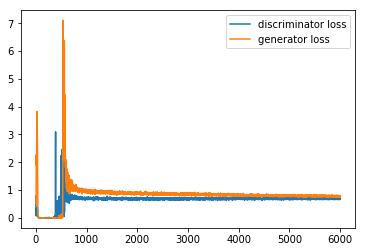

Recent 100 training steps:


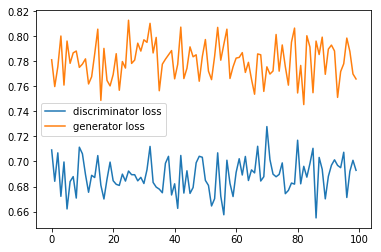

Step 6000 : Generator Loss: [0.76589817, 0.38671875], Discriminator Loss: [ 0.69291484  0.5546875 ]


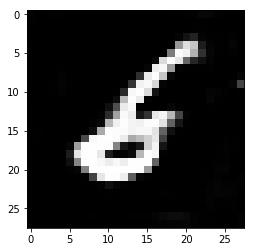

Is True? =  0.58035


In [21]:
train_model(D, G, GAN, train_x, batch_size = 256, epoches = 6000)

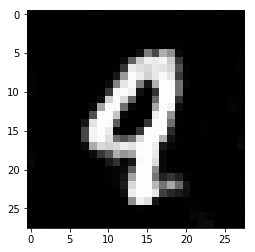

Is True? =  0.477329


In [32]:
test_generator(G, D)

In [23]:
#D.save('discriminator.h5')
#G.save('generator.h5')
#GAN.save('gan.h5')

In [24]:
#D = keras.models.load_model('discriminator.h5')
#G = keras.models.load_model('generator.h5')
#GAN = keras.models.load_model('gan.h5')